In [1157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1158]:
df = pd.read_csv('data/Netflix_Historical_StockPrice2.csv')
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-28,98.339996,101.440002,97.820000,101.209999,101.209999,12432200
1,2016-03-29,101.080002,104.330002,101.000000,104.129997,104.129997,16008900
2,2016-03-30,104.650002,104.910004,101.480003,102.190002,102.190002,14705000
3,2016-03-31,102.430000,103.529999,101.050003,102.230003,102.230003,9747500
4,2016-04-01,102.930000,105.790001,102.470001,105.699997,105.699997,14182400


In [1159]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1.260000e+03
mean,292.419810,296.933730,287.681095,292.472302,292.472302,8.451711e+06
std,135.356764,137.677319,132.811799,135.274699,135.274699,5.513675e+06
min,85.430000,86.500000,84.500000,85.330002,85.330002,1.144000e+06
25%,160.012501,161.159996,157.865002,159.867504,159.867504,5.018600e+06
50%,308.220001,313.744995,302.919998,309.014999,309.014999,6.938700e+06
75%,371.059998,376.107498,364.540001,370.585007,370.585007,1.006235e+07
max,582.450012,593.289978,570.400024,586.340027,586.340027,5.841040e+07


In [1160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1260 non-null   object 
 1   Open       1260 non-null   float64
 2   High       1260 non-null   float64
 3   Low        1260 non-null   float64
 4   Close      1260 non-null   float64
 5   Adj Close  1260 non-null   float64
 6   Volume     1260 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [1161]:
plt.rcParams['figure.figsize'] = (10, 5)

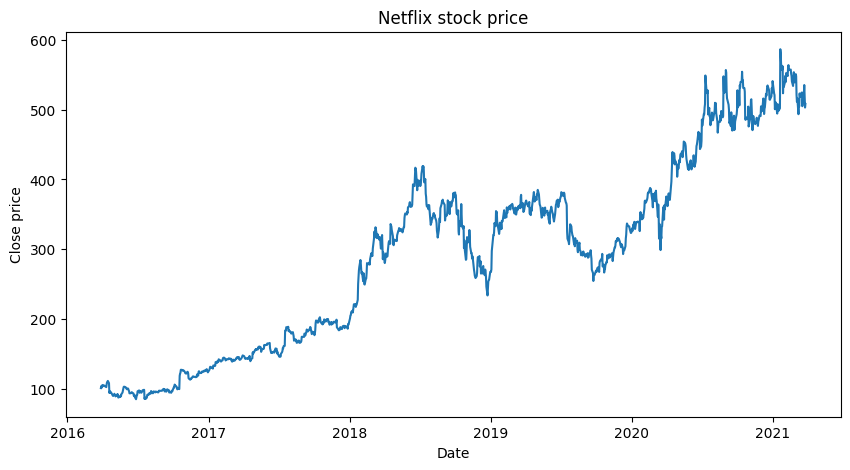

In [1162]:
df.Date = pd.to_datetime(df.Date)

plt.plot(df.Date, df.Close)
plt.title('Netflix stock price')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.show()

Non-stationary :(
p-value: 0.8552248970885346 
adf: -0.6665490596576249 
crit: -2.8638793281844253


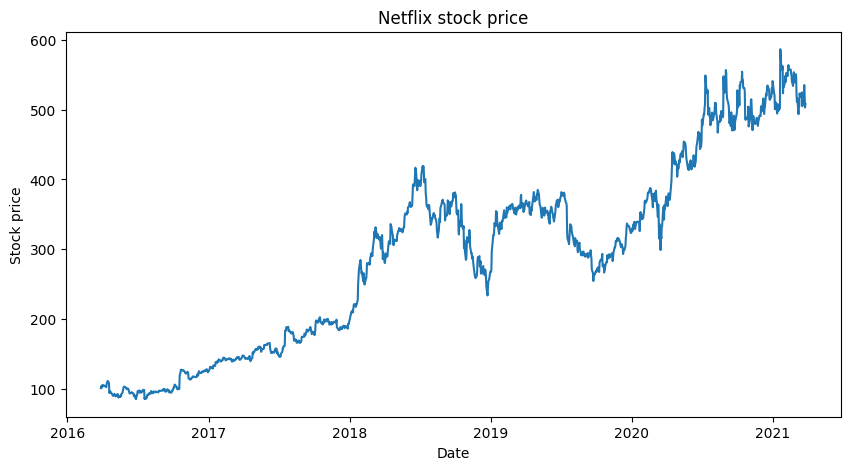

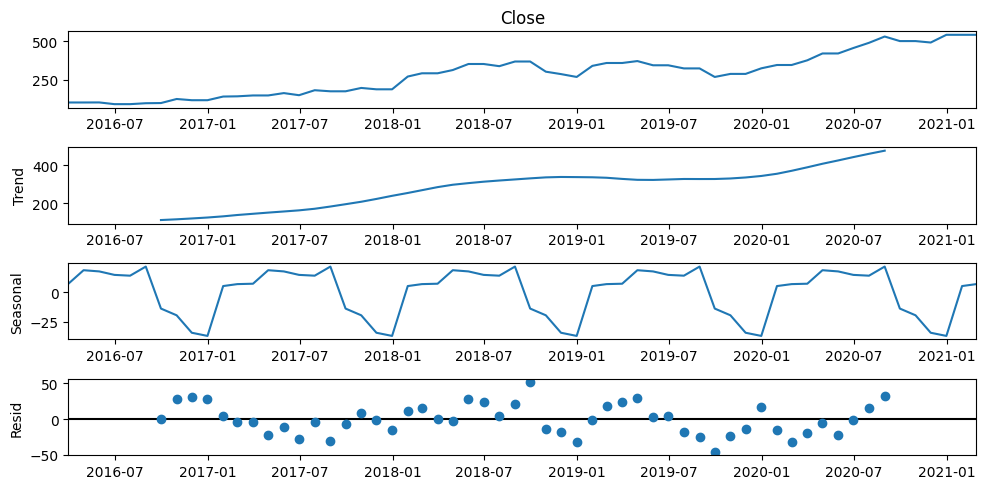

In [1163]:
from urllib.robotparser import RequestRate
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

def isStationary(dataset):
    test = sm.tsa.adfuller(dataset)
    adf = test[0]
    pvalue = test[1]
    crit = test[4]['5%']

    if adf <= crit:
        print('Stationary ^_^\np-value:', pvalue)
    else:
        print('Non-stationary :(\np-value:', pvalue, '\nadf:', adf, '\ncrit:', crit)
    plt.plot(dataset)
    plt.title('Netflix stock price')
    plt.xlabel('Date')
    plt.ylabel('Stock price')
    plt.show()

def seasonalDecompose(dataset):
    dataset.index = pd.to_datetime(dataset.index)
    dataset = dataset.asfreq('1m')
    dataset.fillna(method='ffill', inplace=True)

    desomposed = seasonal_decompose(dataset, model='additive')
    desomposed.plot()
    plt.show()


df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
# df = df.resample('1M').mean()

price = df.Close
isStationary(price)
seasonalDecompose(price)

In [1164]:
from scipy.special import boxcox, inv_boxcox

Non-stationary :(
p-value: 0.05345470226971452 
adf: -2.8349314113120108 
crit: -2.8638793281844253


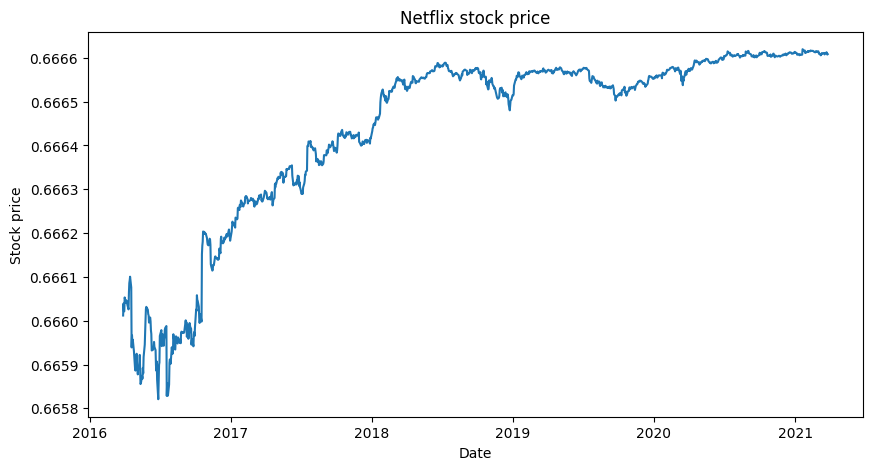

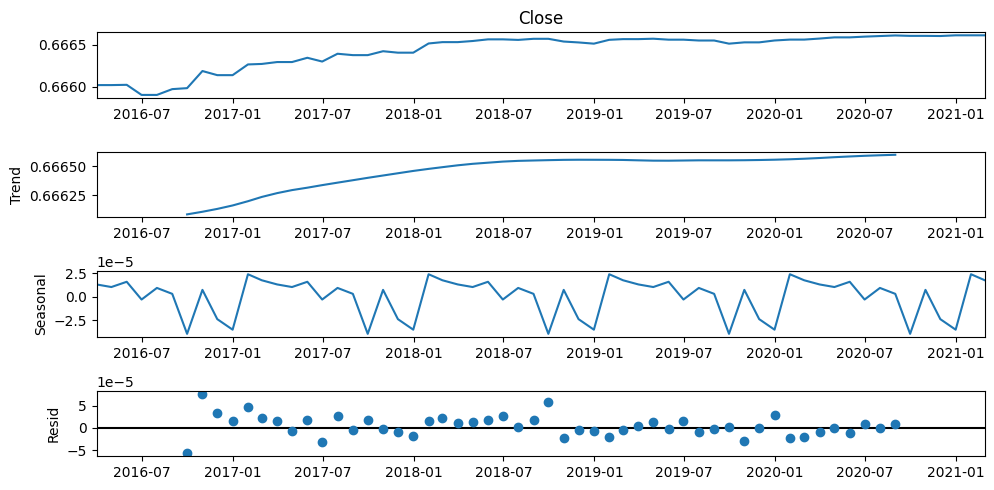

In [1165]:
price1 = boxcox(price, -1.5)
price1.fillna(method='ffill', inplace=True)
isStationary(price1)
seasonalDecompose(price1)

Stationary ^_^
p-value: 7.732238451531517e-18


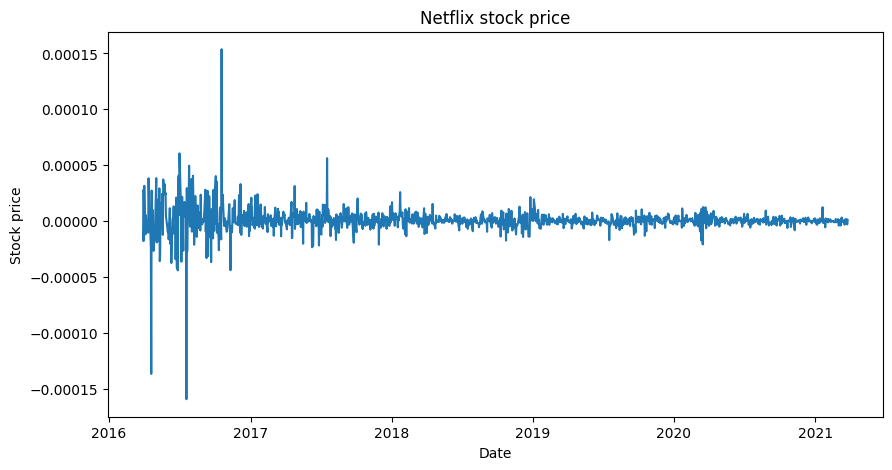

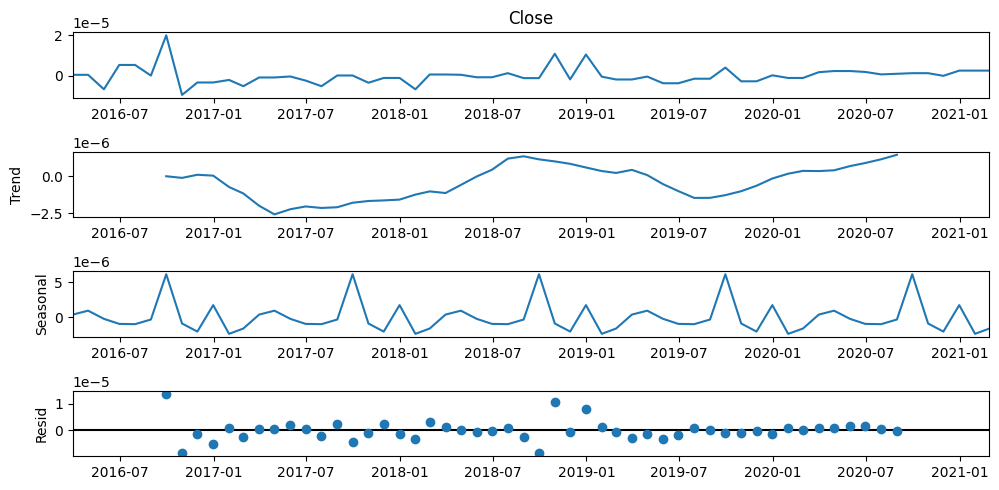

In [1166]:
savedFirst = price1[0]
price2 = price1.diff(1)[1:]
isStationary(price2)
seasonalDecompose(price2)

In [1167]:
def recover(dataset):
    return inv_boxcox([savedFirst] + dataset.cumsum(), -1.5)

## Скользящее среднее

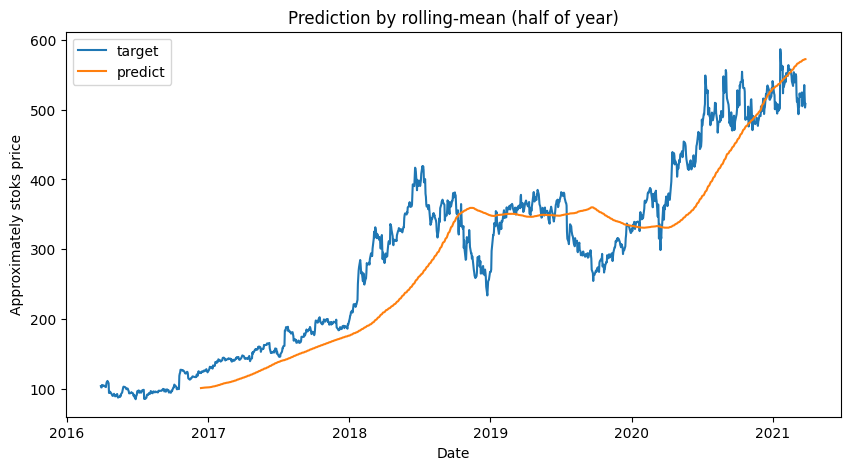

In [1168]:
data = price2

plt.plot(recover(data), label='target')
plt.plot(recover(data.rolling(365 // 2).mean()), label='predict')
plt.title('Prediction by rolling-mean (half of year)')
plt.xlabel('Date')
plt.ylabel('Approximately stoks price')
plt.legend()
plt.show()

## Двойное экспоненциальное сглаживание

In [1169]:
def doubleRollingMean(data, alpha, beta):
    result = data.copy()
    n = len(data)
    if n >= 1:
        resid = data[0]
        trend = data[1] - data[0]
    for i in range(1, n):
        approx = resid + trend
        prevResid, resid = resid, alpha * data[i] + (1 - alpha) * approx
        trend = beta * (resid - prevResid) + (1 - beta) * trend
        result[i] = approx
    return result[1:]

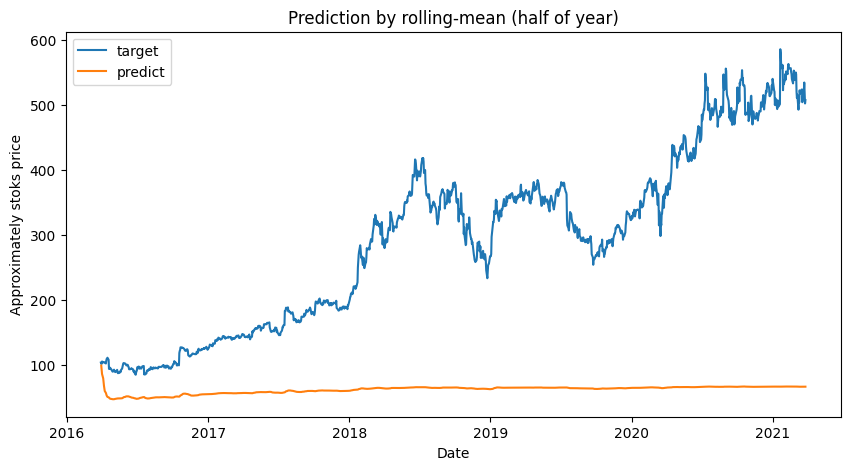

In [1170]:
data = price2

plt.plot(recover(data), label='target')
plt.plot(recover(doubleRollingMean(data, 0.2, 0.2)), label='predict')
plt.title('Prediction by rolling-mean (half of year)')
plt.xlabel('Date')
plt.ylabel('Approximately stoks price')
plt.legend()
plt.show()